In [13]:
import os
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

In [14]:
import os
import wfdb
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the path to the extracted dataset
data_path = r'C:\Users\Bibi Sabar\Desktop\Dissertation\mit-bih-arrhythmia-database-1.0.0'

# Function to load a record and preprocess
def load_and_preprocess(record):
    signal, fields = wfdb.rdsamp(os.path.join(data_path, record))
    annotation = wfdb.rdann(os.path.join(data_path, record), 'atr')
    
    # Use only one channel (e.g., channel 0)
    signal = signal[:, 0].reshape(-1, 1)
    
    # Normalize the signal
    scaler = StandardScaler()
    signal = scaler.fit_transform(signal)
    
    # Segment the signal
    segments = []
    labels = []
    for i in range(len(annotation.sample)):
        if annotation.sample[i] - 99 > 0 and annotation.sample[i] + 160 < len(signal):
            segments.append(signal[annotation.sample[i] - 99 : annotation.sample[i] + 160])
            labels.append(annotation.symbol[i])
    
    return np.array(segments), np.array(labels)

# Function to load and preprocess all records in the dataset
def load_and_preprocess_all_records(data_path):
    all_segments = []
    all_labels = []
    
    for record in os.listdir(data_path):
        if record.endswith('.dat'):
            record_name = record[:-4]  # Remove the file extension
            segments, labels = load_and_preprocess(record_name)
            all_segments.append(segments)
            all_labels.append(labels)
    
    # Concatenate all segments and labels
    all_segments = np.vstack(all_segments)
    all_labels = np.concatenate(all_labels)
    
    return all_segments, all_labels

# Load and preprocess the entire dataset
segments, labels = load_and_preprocess_all_records(data_path)

# Reshape segments to fit the model's expected input shape
segments = segments.reshape(segments.shape[0], segments.shape[1], 1)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(segments, labels_encoded, test_size=0.2, random_state=42)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import numpy as np

# Define a simple CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(259, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
import time

# Capture the start time
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=128)

# Calculate the total training time
total_training_time = time.time() - start_time


Epoch 1/5
704/704 [==============================] - 77s 107ms/step - loss: 0.4168 - accuracy: 0.8983 - val_loss: 0.1949 - val_accuracy: 0.9512
Epoch 2/5
704/704 [==============================] - 75s 106ms/step - loss: 0.2026 - accuracy: 0.9479 - val_loss: 0.1403 - val_accuracy: 0.9620
Epoch 3/5
704/704 [==============================] - 74s 105ms/step - loss: 0.1640 - accuracy: 0.9568 - val_loss: 0.1263 - val_accuracy: 0.9680
Epoch 4/5
704/704 [==============================] - 75s 107ms/step - loss: 0.1429 - accuracy: 0.9616 - val_loss: 0.1098 - val_accuracy: 0.9698
Epoch 5/5
704/704 [==============================] - 75s 106ms/step - loss: 0.1277 - accuracy: 0.9654 - val_loss: 0.1007 - val_accuracy: 0.9726


In [18]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Compute the metrics
overall_accuracy = np.sum(y_pred_classes == y_test) / len(y_test)
overall_sensitivity = recall_score(y_test, y_pred_classes, average='macro') * 100
overall_specificity = (conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])) * 100
overall_precision = precision_score(y_test, y_pred_classes, average='macro') * 100
overall_fscore = f1_score(y_test, y_pred_classes, average='macro') * 100

# Print the results
print(f"Total Training Time: {total_training_time:.2f} seconds")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Overall Sensitivity: {overall_sensitivity:.2f}%")
print(f"Overall Specificity: {overall_specificity:.2f}%")
print(f"Overall Precision: {overall_precision:.2f}%")
print(f"Overall F-Score: {overall_fscore:.2f}%")


704/704 [==============================] - 6s 9ms/step
Total Training Time: 375.78 seconds
Overall Accuracy: 97.26%
Overall Sensitivity: 60.37%
Overall Specificity: 100.00%
Overall Precision: 72.84%
Overall F-Score: 62.95%


F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


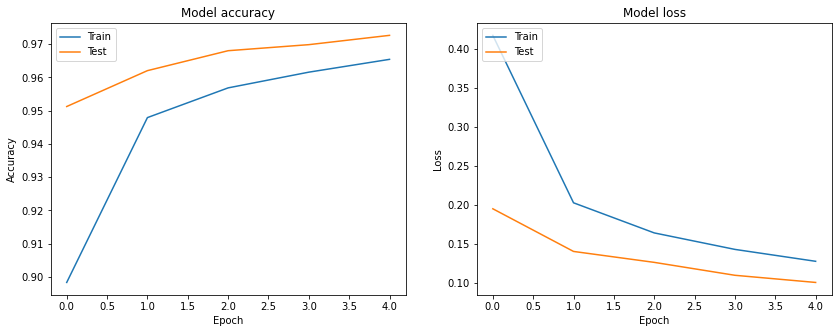

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
